### This script splits the MEGAPOLI dataset into training and testing subsets for fine-tuning. 
Specifically, it allocates 50% of the data to the training set and the remaining 50% to the test set.
The script ensures that at least one row is included in the training set, even if the dataset is small.
The resulting subsets are saved as separate CSV files for further use in fine-tuning machine learning models.

In [5]:
import pandas as pd

# Load the dataset from a CSV file
df = pd.read_csv('../Data/MEGAPOLI_data/MEGAPOLI_Marine.csv')

# Calculate 50% of the total dataset size
percent = int(len(df)*0.8)

# Ensure at least one row is included in the training set
percent = max(1, percent)

# Use slicing to create the training set (first `percent` rows)
train = df[:percent]
# Use slicing to create the test set (remaining rows)
test = df[percent:]

# Save the training set to a CSV file
train.to_csv('../Data/MEGAPOLI_data/MEGAPOLI_Marine_train_50%.csv', index=False)

# Save the test set to a CSV file
test.to_csv('../Data/MEGAPOLI_data/MEGAPOLI_Marine_test_50%.csv', index=False)

This script demonstrates the process of fine-tuning a pre-trained foundation model using MEGAPOLI observational data. The foundation model, originally trained on PartMC simulated data, is adapted through transfer learning to improve its predictions for real-world aerosol mixing state index (Chi). Key steps include:

1. **Data Preprocessing**:
   - Standardize MEGAPOLI data based on the original foundation model's training scaler.
   - Convert data to PyTorch tensors for efficient computation.

2. **Model Architecture**:
   - Utilize a ResNet-like architecture pre-trained on PartMC data.
   - Freeze the majority of layers for transfer learning while fine-tuning a subset.

3. **Fine-tuning**:
   - Optimize model parameters on MEGAPOLI training data.
   - Save the fine-tuned model based on the best Mean Squared Error (MSE).

4. **Evaluation**:
   - Evaluate the fine-tuned model on the MEGAPOLI test dataset using metrics like MSE, RMSE, R², MAE, and MAPE.
   - Save predictions and true values to a CSV file for further analysis.

5. **Visualization**:
   - Scatter plot with density visualization to compare observed and predicted Chi values.
   - Line plot comparing predicted and actual values over sample indices.

This workflow bridges simulated data-driven foundation models with real-world observations, enhancing the practical applicability of aerosol research.

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import random

# Function to set random seed for reproducibility
def set_seed(seed):
    """
    Sets the random seed for reproducibility across numpy, random, and PyTorch.

    Parameters:
    - seed (int): The seed value to ensure reproducibility.
    """
    # Set seed for Python's built-in random module
    random.seed(seed)

    # Set seed for numpy
    np.random.seed(seed)

    # Set seed for PyTorch (CPU and GPU)
    torch.manual_seed(seed)  # CPU
    if torch.cuda.is_available():  # GPU
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior in PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the random seed to ensure reproducibility
seed = 42  # Seed value for reproducibility
set_seed(seed)

### Load the dataset used for training the original model for data normalization

In [7]:
features = ['O3 (ppb)', 'CO (ppb)', 'NO (ppb)', 'NOx (ppb)',
        'ETH (ppb)', 'TOL(ppb)', 'XYL (ppb)', 'ALD2 (ppb)',
       'AONE (ppb)', 'PAR (ppb)', 'OLET (ppb)', 'Temperature(K)', 'RH',
       'BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)']


# Load the dataset used for training the original model for Normalizing
partmc_train_data = pd.read_csv('../Data/PartMC_data/PartMC_train.csv')
X_train = partmc_train_data[features]


### Transfer Learning with ResNet for MEGAPOLI Data

In [57]:
# Load the datasets
megapoli_train_data = pd.read_csv('../Data/MEGAPOLI_data/MEGAPOLI_Marine_test_50%.csv') # e.g. Use 50% fine-tuning training dataset to fine-tune foundation model
megapoli_test_data = pd.read_csv('../Data/MEGAPOLI_data/MEGAPOLI_Marine_train_50%.csv')


# Prepare MEGAPOLI data
X_megapoli_train = megapoli_train_data[features]
y_megapoli_train = megapoli_train_data.iloc[:, 23]

X_megapoli_test = megapoli_test_data[features]
y_megapoli_test = megapoli_test_data.iloc[:, 23]

# Standardize the data using the scaler from the original model's training data
scaler_X = StandardScaler()
X_train2 = scaler_X.fit_transform(X_train)  #  Fit on the original training data, X_train2 ensures no need to reload the original dataset (PartMC)
X_megapoli_train = scaler_X.transform(X_megapoli_train)
X_megapoli_test = scaler_X.transform(X_megapoli_test)


# Convert to PyTorch tensors
X_megapoli_train_tensor = torch.tensor(X_megapoli_train, dtype=torch.float32)
y_megapoli_train_tensor = torch.tensor(y_megapoli_train, dtype=torch.float32)
X_megapoli_test_tensor = torch.tensor(X_megapoli_test, dtype=torch.float32)
y_megapoli_test_tensor = torch.tensor(y_megapoli_test, dtype=torch.float32)





# Create a DataLoader for the training data
batch_size = 1

megapoli_train_dataset = TensorDataset(X_megapoli_train_tensor, y_megapoli_train_tensor)
megapoli_train_loader = DataLoader(megapoli_train_dataset, batch_size=batch_size, shuffle=True)


# Define the ResNet-like model architecture
class ResNetBlock(nn.Module):
    def __init__(self, hidden_size):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
    
    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, in_features, num_blocks, hidden_size):
        super(ResNet, self).__init__()
        self.fc_in = nn.Linear(in_features, hidden_size)
        self.relu = nn.ReLU()
        self.blocks = nn.Sequential(
            *[ResNetBlock(hidden_size) for _ in range(num_blocks)]
        )
        self.fc_out = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out = self.fc_in(x)
        out = self.relu(out)
        out = self.blocks(out)
        out = self.fc_out(out)
        return out

# Initialize the model and load pre-trained weights
input_size = X_megapoli_train_tensor.shape[1]
num_blocks = 15
hidden_size = 512
model = ResNet(input_size, num_blocks, hidden_size)

# Load foundation model
model.load_state_dict(torch.load('../Model/Foundation_Model.pth'))


# Freeze the first `num_frozen_blocks` layers for transfer learning
num_frozen_blocks = 13
for i, block in enumerate(model.blocks):
    if i < num_frozen_blocks:
        for param in block.parameters():
            param.requires_grad = False

# Confirm the layers that are frozen
print("Number of frozen layers:", num_frozen_blocks)
for name, param in model.named_parameters():
    if not param.requires_grad:
        print(f"Frozen layer: {name}")



# Define the loss function and optimizer
weight_decay = 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=weight_decay)

# Perform fine-tuning (training) on MEGAPOLI data
num_epochs =  15 # Number of fine-tuning epochs
best_mse = float('inf')
best_model = None

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in megapoli_train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.view(-1), y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    
    epoch_loss = running_loss / len(megapoli_train_loader.dataset)
    
    # Save the best model based on validation loss
    if epoch_loss < best_mse:
        best_mse = epoch_loss
        best_model = model.state_dict()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}')

# Save the fine-tuned model
model.load_state_dict(best_model)
torch.save(model.state_dict(), '../Model/best_resnet_model_finetuned_50%_test.pth')


C:\Users\1\AppData\Local\Temp\ipykernel_90884\811829109.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../Model/Foundation_Model.pth'

Number of frozen layers: 13
Frozen layer: blocks.0.fc1.weight
Frozen layer: blocks.0.fc1.bias
Frozen layer: blocks.0.fc2.weight
Frozen layer: blocks.0.fc2.bias
Frozen layer: blocks.1.fc1.weight
Frozen layer: blocks.1.fc1.bias
Frozen layer: blocks.1.fc2.weight
Frozen layer: blocks.1.fc2.bias
Frozen layer: blocks.2.fc1.weight
Frozen layer: blocks.2.fc1.bias
Frozen layer: blocks.2.fc2.weight
Frozen layer: blocks.2.fc2.bias
Frozen layer: blocks.3.fc1.weight
Frozen layer: blocks.3.fc1.bias
Frozen layer: blocks.3.fc2.weight
Frozen layer: blocks.3.fc2.bias
Frozen layer: blocks.4.fc1.weight
Frozen layer: blocks.4.fc1.bias
Frozen layer: blocks.4.fc2.weight
Frozen layer: blocks.4.fc2.bias
Frozen layer: blocks.5.fc1.weight
Frozen layer: blocks.5.fc1.bias
Frozen layer: blocks.5.fc2.weight
Frozen layer: blocks.5.fc2.bias
Frozen layer: blocks.6.fc1.weight
Frozen layer: blocks.6.fc1.bias
Frozen layer: blocks.6.fc2.weight
Frozen layer: blocks.6.fc2.bias
Frozen layer: blocks.7.fc1.weight
Frozen layer: 

### Evaluate on MEGAPOLI Test Data and Visualization

MSE: 0.0023, RMSE: 0.0475, R2: 0.3977, MAE: 0.0371, MAPE: 6.1519


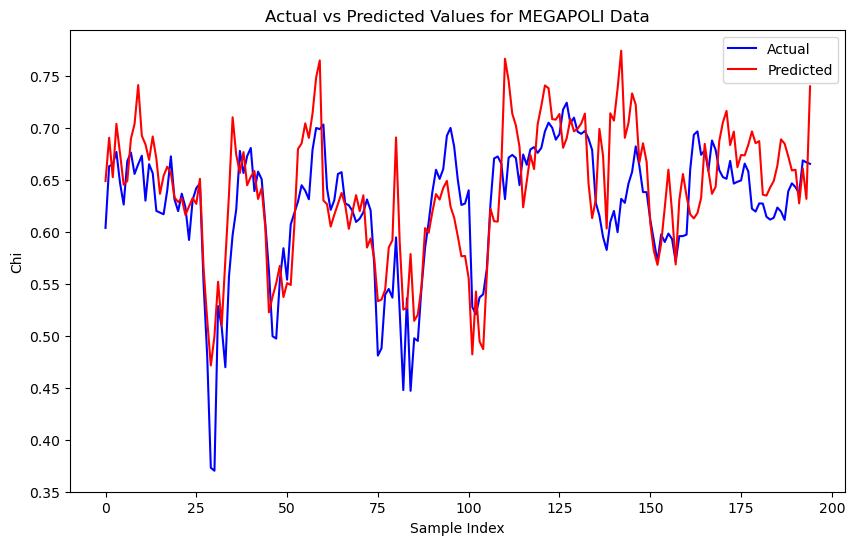

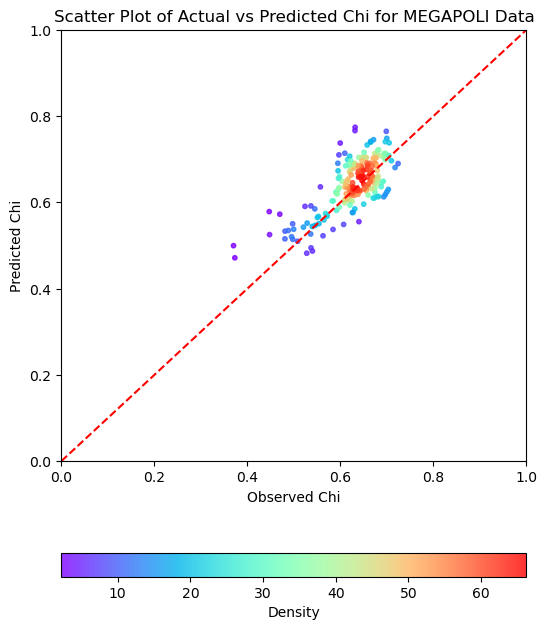

In [ ]:
# Set the model to evaluation mode
model.eval()
# Make predictions and calculate performance metrics
with torch.no_grad(): # Disable gradient computation for evaluation
    # Predict on the MEGAPOLI test dataset
    y_test_predictions = model(X_megapoli_test_tensor).view(-1)
    mse = mean_squared_error(y_megapoli_test_tensor.numpy(), y_test_predictions.numpy())
    rmse = np.sqrt(mse)
    r2 = r2_score(y_megapoli_test_tensor.numpy(), y_test_predictions.numpy())
    mae = np.mean(np.abs(y_test_predictions.numpy() - y_megapoli_test_tensor.numpy()))
    mape = np.mean(np.abs((y_test_predictions.numpy() - y_megapoli_test_tensor.numpy()) / y_megapoli_test_tensor.numpy())) * 100

    results_df = pd.DataFrame({
        'y_true': y_megapoli_test_tensor.numpy(),
        'y_pred': y_test_predictions.numpy()
    })

    # Save to CSV (e.g. Fine-tuned by 50% of fine-tuning training dataset (25% of the MEGAPOLI data), tested model by the fine-tuning testing dataset)
    # results_df.to_csv('../Data/Fine_tuned_Results_different_data_size/Fine_tuning_20%Data_test.csv', index=False)

# Calculate performance metrics
# mse = mean_squared_error(y_test_true, y_test_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test_true, y_test_pred)
# mae = mean_absolute_error(y_test_true, y_test_pred)
# mape = np.mean(np.abs((y_test_true - y_test_pred) / y_test_true)) * 100


# Print performance metrics
print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}')


# Plot actual vs. predicted values over sample indices
plt.figure(figsize=(10, 6))
plt.plot(y_megapoli_test_tensor.numpy(), label='Actual', color='b')
plt.plot(y_test_predictions.numpy(), label='Predicted', color='r')
plt.xlabel('Sample Index')
plt.ylabel('Chi')
plt.title('Actual vs Predicted Values for MEGAPOLI Data')
plt.legend()
plt.show()





# Scatter plot with density visualization
# Prepare data for scatter plot
actual_values = y_megapoli_test_tensor.numpy()
predicted_values = y_test_predictions.numpy()


# Compute point density
xy = np.vstack([actual_values, predicted_values])
z = gaussian_kde(xy)(xy)

# Create scatter plot with density as color
fig, ax = plt.subplots(figsize=(6, 8))
scatter = plt.scatter(actual_values, predicted_values, c=z, s=10, cmap='rainbow', alpha=0.8)
plt.colorbar(scatter, label='Density', orientation='horizontal')

# Add y = x reference line
plt.plot([0, 1], [0, 1], color='r', linestyle='--')

# Set axis labels, limits, and title
plt.xlabel('Observed Chi')
plt.ylabel('Predicted Chi')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Scatter Plot of Actual vs Predicted Chi for MEGAPOLI Data')

# Display the scatter plot
plt.show()

### Load best fine-tuned model

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import random



features = ['O3 (ppb)', 'CO (ppb)', 'NO (ppb)', 'NOx (ppb)',
        'ETH (ppb)', 'TOL(ppb)', 'XYL (ppb)', 'ALD2 (ppb)',
       'AONE (ppb)', 'PAR (ppb)', 'OLET (ppb)', 'Temperature(K)', 'RH',
       'BC (ug/m3)', 'OA (ug/m3)', 'NH4 (ug/m3)', 'NO3 (ug/m3)', 'SO4 (ug/m3)']

# Load the datasets
partmc_train_data = pd.read_csv('../Data/PartMC_data/PartMC_train.csv')

megapoli_train_data = pd.read_csv('../Data/MEGAPOLI_data/MEGAPOLI_Marine_train_50%.csv')
# megapoli_test_data = pd.read_csv('../Data/MEGAPOLI_data/MEGAPOLI_Marine_train_50%.csv')
megapoli_test_data = pd.read_csv('../Data/MEGAPOLI_data/MEGAPOLI_Marine.csv')


X_train = partmc_train_data[features]

# Prepare MEGAPOLI data
X_megapoli_train = megapoli_train_data[features]
y_megapoli_train = megapoli_train_data.iloc[:, 23]

X_megapoli_test = megapoli_test_data[features]
y_megapoli_test = megapoli_test_data.iloc[:, 23]

# Standardize the data
scaler_X = StandardScaler()
X_train2 = scaler_X.fit_transform(X_train)
X_megapoli_train = scaler_X.transform(X_megapoli_train)
X_megapoli_test = scaler_X.transform(X_megapoli_test)

# Convert to PyTorch tensors
X_megapoli_train_tensor = torch.tensor(X_megapoli_train, dtype=torch.float32)
y_megapoli_train_tensor = torch.tensor(y_megapoli_train, dtype=torch.float32)
X_megapoli_test_tensor = torch.tensor(X_megapoli_test, dtype=torch.float32)
y_megapoli_test_tensor = torch.tensor(y_megapoli_test, dtype=torch.float32)

In [18]:
# # Define the ResNet-like block structure
class ResNetBlock(nn.Module):
    def __init__(self, hidden_size):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
    
    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = out + residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, in_features, num_blocks, hidden_size):
        super(ResNet, self).__init__()
        self.fc_in = nn.Linear(in_features, hidden_size)
        self.relu = nn.ReLU()
        self.blocks = nn.Sequential(
            *[ResNetBlock(hidden_size) for _ in range(num_blocks)]
        )
        self.fc_out = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out = self.fc_in(x)
        out = self.relu(out)
        out = self.blocks(out)
        out = self.fc_out(out)
        return out

# Instantiate the ResNet model
input_size = X_megapoli_train_tensor.shape[1]
num_blocks = 15
hidden_size = 512
model = ResNet(input_size, num_blocks, hidden_size)

# model.load_state_dict(torch.load('../Model/best_resnet_model_finetuned_25%.pth'))
model.load_state_dict(torch.load('../Model/Foundation_Model.pth'))

C:\Users\1\AppData\Local\Temp\ipykernel_127120\3858480248.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../Model/Foundation_Model.pt

<All keys matched successfully>

MSE: 0.0029, RMSE: 0.0543, R2: 0.4355, MAE: 0.0386, MAPE: 6.7414


Text(0.31, 0.79, 'R$^2$=0.4355 \nRMSE=0.0543 \nMAE=0.0386')

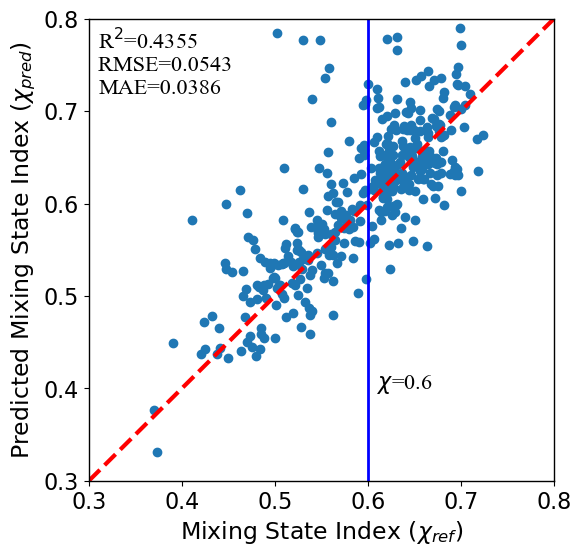

In [19]:
model.eval()
with torch.no_grad():
    y_test_predictions = model(X_megapoli_test_tensor).view(-1)
    mse = mean_squared_error(y_megapoli_test_tensor.numpy(), y_test_predictions.numpy())
    rmse = np.sqrt(mse)
    r2 = r2_score(y_megapoli_test_tensor.numpy(), y_test_predictions.numpy())
    # r2 = 1 - mse / np.var(y_megapoli_test_tensor[0:298].numpy())
    mae = np.mean(np.abs(y_test_predictions.numpy() - y_megapoli_test_tensor.numpy()))
    mape = np.mean(np.abs((y_test_predictions.numpy() - y_megapoli_test_tensor.numpy()) / y_megapoli_test_tensor.numpy())) * 100

    results_df = pd.DataFrame({
        'Time': megapoli_test_data['Time'],
        'y_true': y_megapoli_test_tensor.numpy(),
        'y_pred': y_test_predictions.numpy()
    })

    # Save to CSV
    # results_df.to_csv('../Data/Fine_tuned_Results_different_data_size/Fine_tuning_25%Data1.csv', index=False)

# Calculate performance metrics
# mse = mean_squared_error(y_test_true, y_test_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test_true, y_test_pred)
# mae = mean_absolute_error(y_test_true, y_test_pred)
# mape = np.mean(np.abs((y_test_true - y_test_pred) / y_test_true)) * 100

mse, rmse, r2, mae, mape

print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}')

plt.figure(figsize=(6, 6))

scatter = plt.scatter(y_megapoli_test_tensor.numpy(), y_test_predictions.numpy())
plt.xlabel('Mixing State Index ($\chi_{ref}$)',fontsize=17)
plt.ylabel('Predicted Mixing State Index ($\chi_{pred}$)',fontsize=17)
plt.tick_params(axis='both', labelsize=16)
plt.xticks(np.arange(0, 1.2, 0.1))
plt.yticks(np.arange(0, 1.2, 0.1))
plt.xlim(0.3, 0.8)
plt.ylim(0.3, 0.8)
plt.plot([0.3, 0.8], [0.3, 0.8], color='r', linestyle='--', linewidth = 3)

# 添加Chi=0.6的水平线和垂直线
# plt.axhline(y=0.6, color='b', linestyle='-', linewidth=2)
plt.axvline(x=0.6, color='b', linestyle='-', linewidth=2)

# 添加Chi=0.6的标注
# plt.text(0.4, 0.61, 'Chi=0.6', color='b', fontsize=14, fontname='Times New Roman')
plt.text(0.61, 0.4, '$\chi$=0.6', color='black', fontsize=16, fontname='Times New Roman', rotation=0)

for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)


textstr = f'R$^2$={r2:.4f} \nRMSE={rmse:.4f} \nMAE={mae:.4f}'
plt.text(0.31, 0.79, textstr, fontsize=16, fontname='Times New Roman', verticalalignment='top')

# plt.savefig('Best.png', dpi=400, bbox_inches='tight')
